C:\Users\Sajede Harraz\AppData\Local\Temp\ipykernel_4156\4005529838.py:70: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  cu_qubits = [q[0].index, anc[0].index]
C:\Users\Sajede Harraz\AppData\Local\Temp\ipykernel_4156\4005529838.py:75: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  noise_model.add_quantum_error(cu_error, 'cu', [q[i].index, anc[i].index])
C:\Users\Sajede Harraz\AppData\Local\

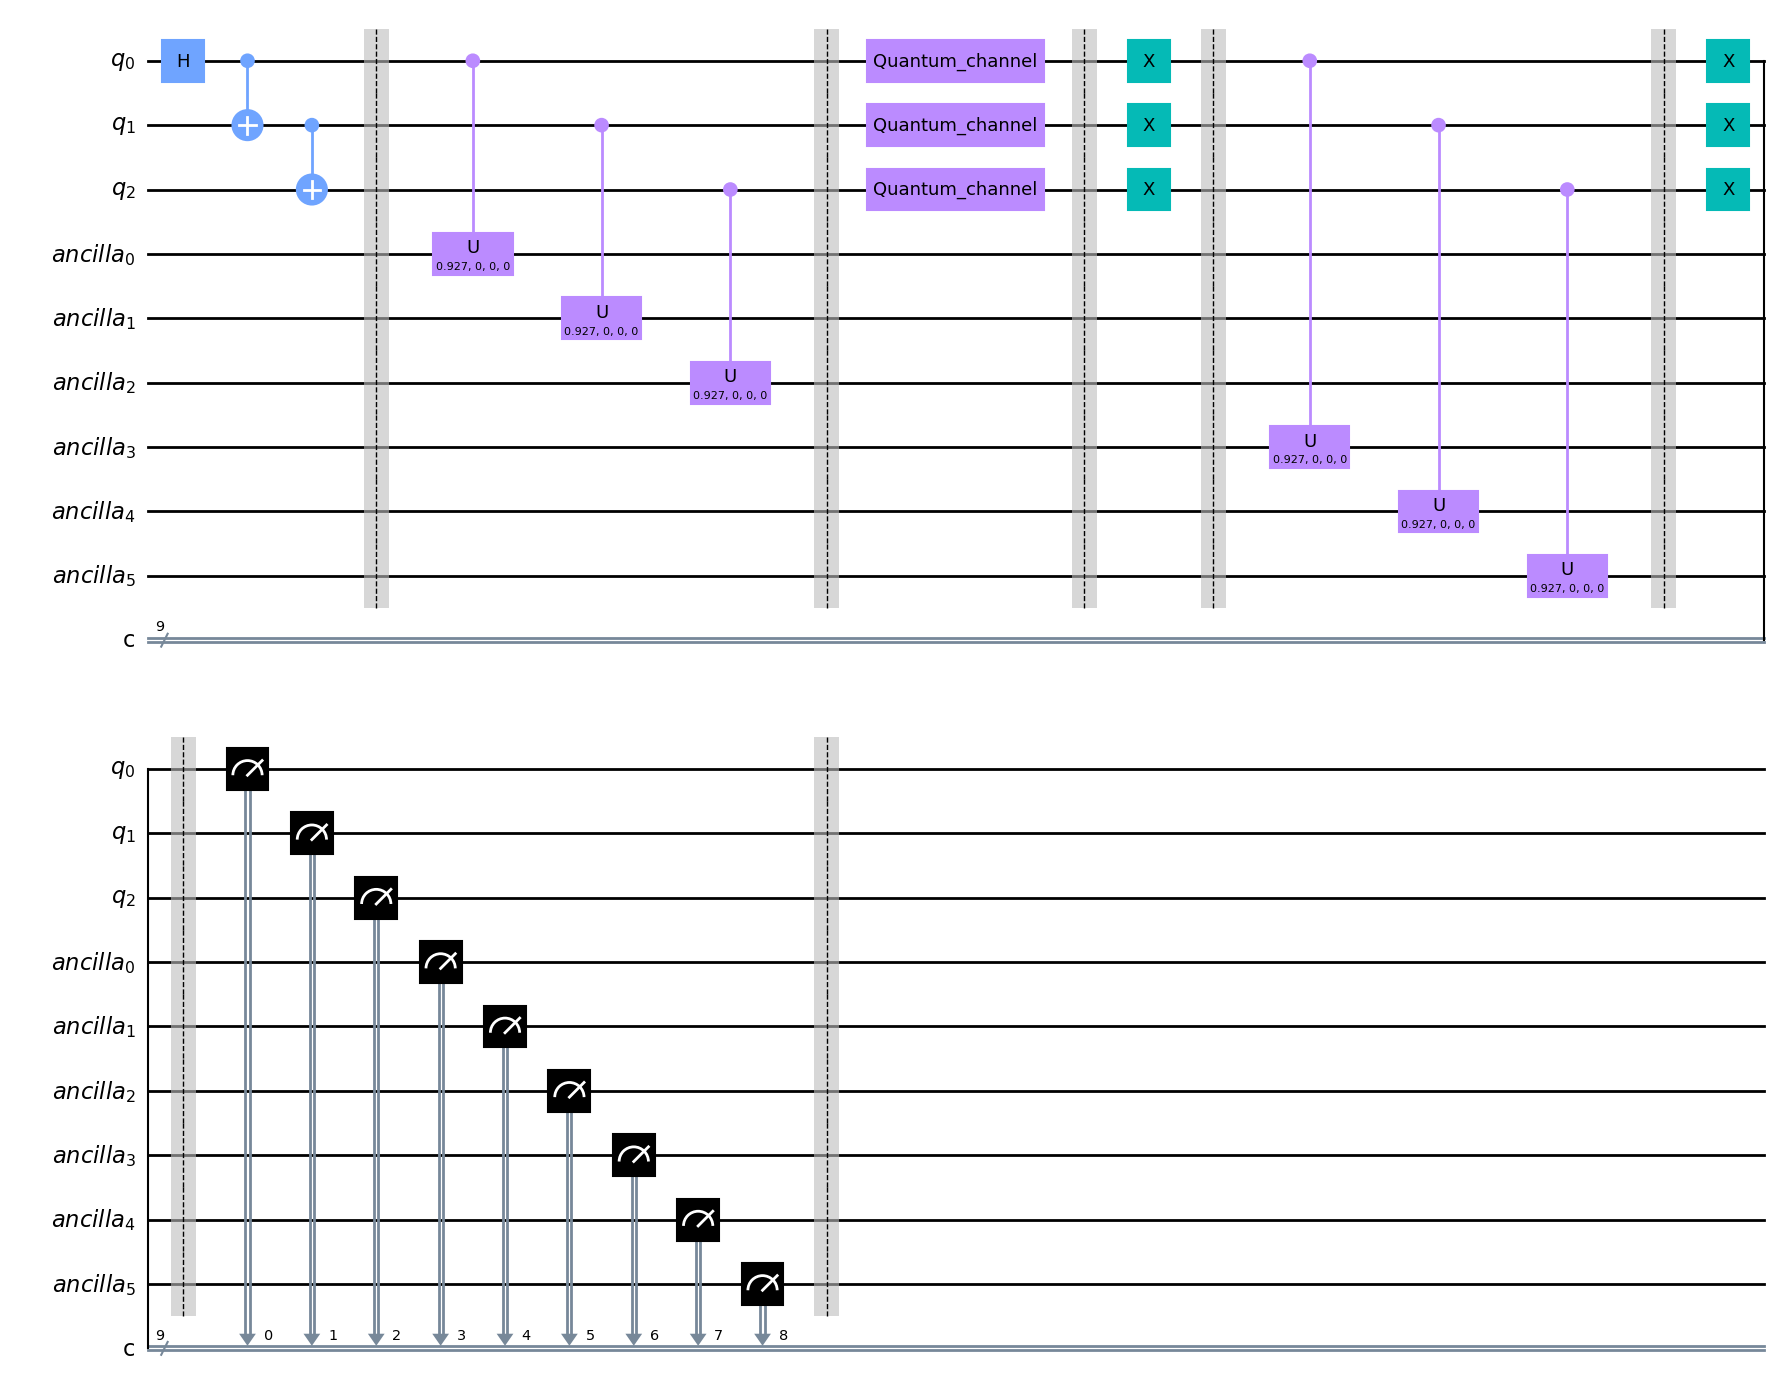

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister,transpile, assemble, execute, Aer
from qiskit.quantum_info import Kraus, SuperOp, Operator, partial_trace, DensityMatrix, Statevector
from qiskit.visualization import plot_bloch_multivector, plot_state_city,  circuit_drawer
from qiskit.circuit import Parameter
from qiskit.providers.aer.noise import amplitude_damping_error,NoiseModel, depolarizing_error, ReadoutError
from qiskit.extensions import UnitaryGate
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
import numpy as np

# Create a quantum circuit
q = QuantumRegister(3, 'q')
anc = QuantumRegister(6, 'ancilla')
c = ClassicalRegister(9, 'c')
qc = QuantumCircuit(q, anc, c)

#Define the damping parameter for the amplitude damping channel
r = 0.3

# Creat 3-qubit GHZ state
qc.h(q[0])
qc.cx(q[0], q[1])
qc.cx(q[1], q[2])
qc.barrier()

#Employing measurement on all qubits 
p=0.2
t=4*np.arctan((1-np.sqrt(1-p))/np.sqrt(p))

qc.cu(t, 0, 0, 0, q[0], anc[0])
qc.cu(t, 0, 0, 0, q[1], anc[1])
qc.cu(t, 0, 0, 0, q[2], anc[2])

qc.barrier()

# Sending all qubits through amplitude damping channel to communication parties
error =amplitude_damping_error(r, excited_state_population=0, canonical_kraus=True)

qc.append(error, [0])
qc.append(error, [1])
qc.append(error, [2]) 
qc.barrier()

#changing structure of the density matrix
qc.x(q)
qc.barrier()

#Employing measurement on all qubits 
p=0.2
t=4*np.arctan((1-np.sqrt(1-p))/np.sqrt(p))

qc.cu(t, 0, 0, 0, q[0], anc[3])
qc.cu(t, 0, 0, 0, q[1], anc[4])
qc.cu(t, 0, 0, 0, q[2], anc[5]) 
qc.barrier()

#changing structure of the density matrix
qc.x(q)
qc.barrier()


####################Considering quantum gates error#######################
#Depolarizing error of CU and CX gate:
cu_error_rate = 0.01 
cx_error_rate = 0.0

# Create a depolarizing error for the CU gate
cu_error = depolarizing_error(cu_error_rate, 2) 

cu_qubits = [q[0].index, anc[0].index]

# Create a noise model and add the CU error to it for the specified qubits
noise_model = NoiseModel()
for i in range(3):
    noise_model.add_quantum_error(cu_error, 'cu', [q[i].index, anc[i].index])
    noise_model.add_quantum_error(cu_error, 'cu', [q[i].index, anc[3+i].index])

# Create a depolarizing error for the CX gate
cx_error = depolarizing_error(cx_error_rate, 2)

qubit_pair1=[q[0].index, q[1].index]
qubit_pair2=[q[1].index, q[2].index]

# Add the CX error to the noise model for the specified qubits
noise_model.add_quantum_error(cx_error, 'cx', qubit_pair1)
noise_model.add_quantum_error(cx_error, 'cx', qubit_pair2)
###########################################################################

nc=9
qc.measure(range(nc),range(nc))
qc.barrier()

# Visualize the circuit
qc.draw('mpl')

In [2]:
#qc=qc.reverse_bits ()
Shots_n=100000
method = "statevector"
backend = AerSimulator(method="statevector")
#density_matrix statevector
job = backend.run(qc, method=method, noise_model=noise_model, shots=Shots_n)  # Run the simulation
result = job.result()  # Get the simulation result

counts = result.get_counts()  # Get the measurement counts
print(counts)

{'001111100': 5, '100011011': 43, '001000110': 763, '100000001': 285, '000110111': 529, '010101001': 13, '000000000': 25421, '010100001': 77, '000001000': 180, '001111110': 17, '001000000': 6356, '000000110': 3063, '000000111': 8580, '010000000': 6376, '000111011': 48, '000100101': 780, '101001000': 16, '000001110': 752, '000111010': 14, '000100110': 729, '000001111': 2161, '000000101': 3051, '000110011': 212, '000101101': 198, '001000010': 261, '000000100': 1127, '010101000': 2, '000000001': 1036, '000101010': 63, '000110110': 196, '100000000': 6354, '000010101': 718, '100011010': 17, '100000010': 270, '000000011': 2989, '011000000': 1592, '000100111': 2246, '100100010': 69, '000011101': 200, '000111101': 35, '000100011': 819, '010111100': 8, '001010110': 200, '001101010': 17, '100101011': 53, '110000000': 1610, '000111100': 17, '000100100': 301, '000001101': 855, '010010101': 187, '000010111': 2124, '000001001': 317, '010100000': 33, '000111110': 44, '000100010': 261, '000001011': 76

success: 46336 , fail: 53664 , total: 100000
Bell states counts: {'000000000': 25421, '000000110': 3063, '000000111': 8580, '000000101': 3051, '000000100': 1127, '000000001': 1036, '000000011': 2989, '000000010': 1069}
Bell new: {'000': 25421, '110': 3063, '111': 8580, '101': 3051, '100': 1127, '001': 1036, '011': 2989, '010': 1069}
probability of sucecess 0.46336
Fidelity= 0.6856250316340857


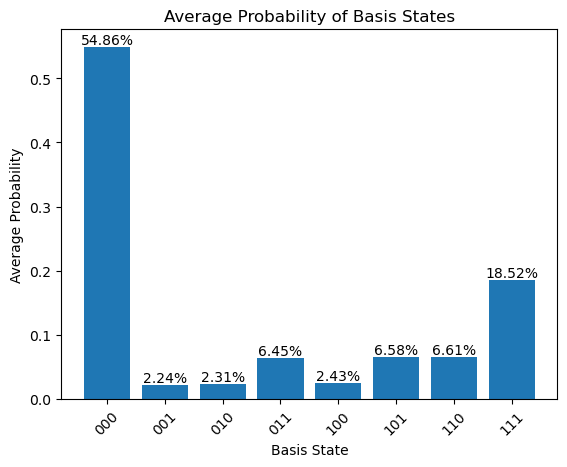

In [3]:
success, fail = 0, 0
Bell_states = {}
Bell_new= {}
for jj in counts:
        if (jj[0]==jj[1]==jj[2]==jj[3]==jj[4]==jj[5]=='0'): #To choose the measurement results corresponding to M
            success += counts[jj]
            Bell_state = jj
            if Bell_state in Bell_states:
                Bell_states[Bell_state] += counts[jj]
            else:
                Bell_states[Bell_state] = counts[jj]
        else:
            fail += counts[jj]
            
total = success + fail

# Extract the last character from each Bell state and store it in Bell_new as a dictionary
for i in Bell_states:
    last_char = i[6:]
    if last_char in Bell_new:
        Bell_new[last_char] += Bell_states[i]
    else:
        Bell_new[last_char] = Bell_states[i]

print('success:', success, ',', 'fail:', fail, ',', 'total:', total)
print('Bell states counts:', Bell_states)
print('Bell new:', Bell_new)
print('probability of sucecess',success/total)

# Convert counts to a sorted list of probabilities
basis_states = ['000', '001', '010', '011','100','101','110','111']
probabilities = [Bell_new.get(state, 0) / success for state in basis_states] # Normalized state
#probabilities = [Bell_new.get(state, 0) / Shots_n for state in basis_states] # Un-normalized state

#Finding probabilites for fidelity:
p11 = probabilities[basis_states.index('000')]
p88 = probabilities[basis_states.index('111')]
p18=np.sqrt(p11)*np.sqrt(p88)
Fid=1/2*(p11+p88)+p18
print('Fidelity=',Fid)

# Plot the probabilities as a bar graph
plt.bar(basis_states, probabilities)
plt.xlabel('Basis State')
plt.ylabel('Average Probability')
plt.title(f'Average Probability of Basis States')
plt.xticks(rotation=45)
for i, prob in enumerate(probabilities):
    plt.text(basis_states[i], prob, f'{prob * 100:.2f}%', ha='center', va='bottom')
plt.show()